In [11]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [19]:
df.shape

(679912, 72)

In [16]:
df = pd.read_csv("Bussiness.csv")

df = df.drop("Unnamed: 0", axis=1)

X = df.drop('LabelIndex', axis=1).values
y = df['LabelIndex'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
class SimpleNN(nn.Module):
   def __init__(self):
      super(SimpleNN, self).__init__()
      self.fc1 = nn.Linear(71, 128)
      self.fc2 = nn.Linear(128, 256)
      self.fc3 = nn.Linear(256, 128)
      self.fc4 = nn.Linear(128, 64)
      self.fc5 = nn.Linear(64, 12)

      self.flat = nn.Flatten()
      self.relu = nn.ReLU()

   def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [18]:
model = SimpleNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
 
for epoch in range(10):
  model.train()
  running_loss = 0.0

  for inputs, labels in train_loader:
    
    optimizer.zero_grad()
  
    outputs = model(inputs)
 
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
   
    running_loss += loss.item() * inputs.size(0)
 
  epoch_loss = running_loss / len(train_loader.dataset)
  print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

Epoch 1, Loss: 1.2757
Epoch 2, Loss: 0.7807
Epoch 3, Loss: 0.7106
Epoch 4, Loss: 0.6786
Epoch 5, Loss: 0.6599
Epoch 6, Loss: 0.6508
Epoch 7, Loss: 0.6409
Epoch 8, Loss: 0.6352
Epoch 9, Loss: 0.6298
Epoch 10, Loss: 0.6260


In [20]:
from sklearn.metrics import classification_report

model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     11291
           1       0.94      0.17      0.29     11430
           2       0.00      0.00      0.00     11434
           3       1.00      1.00      1.00     11151
           4       0.67      0.88      0.76     11507
           5       0.91      0.98      0.94     11338
           6       0.45      0.79      0.58     11211
           7       0.62      0.79      0.69     11255
           8       0.95      0.98      0.96     11252
           9       0.45      0.02      0.04     11382
          10       0.43      0.71      0.54     11283
          11       0.58      0.99      0.73     11449

    accuracy                           0.69    135983
   macro avg       0.66      0.69      0.62    135983
weighted avg       0.66      0.69      0.62    135983



c:\Users\acasalro\AppData\Local\miniconda3\envs\ia\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acasalro\AppData\Local\miniconda3\envs\ia\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acasalro\AppData\Local\miniconda3\envs\ia\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

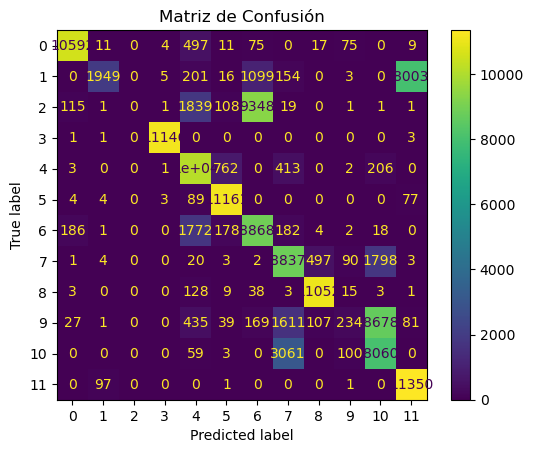

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('Matriz de Confusión')
plt.show()
